# Imports

In [1]:
import os, random, cv2, gc, torch, timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.nn.functional as F

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Hyperparameter and Environment Configuration

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/kaggle/input/ben-graham-preprocessed-dataset" 
BATCH_SIZE = 16
ACCUM_STEPS = 4 
EPOCHS = 50
LR = 1e-3

# Data Preparation

In [3]:
# LOADING DATA
all_paths, all_labels = [], []
for label in ['0', '1', '2', '3', '4']:
    folder = os.path.join(DATA_DIR, label)
    if not os.path.exists(folder): continue
    imgs = [os.path.join(folder, f) for f in os.listdir(folder)]
    all_paths.extend(imgs)
    all_labels.extend([int(label)] * len(imgs))

X_train,X_test, y_train,y_test = train_test_split(
    all_paths, all_labels, test_size=0.15, stratify=all_labels, random_state=42
)


class BalancedDRDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths, self.labels, self.transform = paths, labels, transform
    
    def __len__(self): return len(self.paths)
    
    def __getitem__(self, idx):
        # Image is already 640px and Ben Graham filtered!
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.labels[idx])
        

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use shuffle=True instead of a Sampler since the data is already balanced on disk
train_loader = DataLoader(BalancedDRDataset(X_train, y_train, train_transform), 
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(BalancedDRDataset(X_test, y_test, val_transform), 
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Model architecture

In [4]:
# import torch.nn as nn
# import torch.nn.functional as F

# class CustomHighResDR(nn.Module):
#     def __init__(self):
#         super(CustomHighResDR, self).__init__()
#         # Deeper architecture to handle 640px and learn from scratch
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3), # 320x320
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2, padding=1),                # 160x160

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),                                  # 80x80

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),                                  # 40x40

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.AdaptiveAvgPool2d(1)                              # 1x1
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(256, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(512, 5)
#         )

#         # HE INITIALIZATION: Essential for scratch models to 'wake up'
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         return self.classifier(x)

# # Replace the timm line with this:
# model = CustomHighResDR().to(DEVICE)

In [5]:


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # This "shortcut" is the secret sauce
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # Add the original input back!
        return F.relu(out)

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) # Output: 320x320
        
        self.layer1 = ResidualBlock(64, 64, stride=2)   # 160x160
        self.layer2 = ResidualBlock(64, 128, stride=2)  # 80x80
        self.layer3 = ResidualBlock(128, 256, stride=2) # 40x40
        self.layer4 = ResidualBlock(256, 512, stride=2) # 20x20
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 5)

    def forward(self, x):
        # This is the 'instruction manual' the model was missing!
        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1) # Flatten the 512 features for the FC layer
        x = self.fc(x)
        return x

# Now re-initialize and move to GPU
model = CustomModel().to(DEVICE)
print("Model fixed! Ready for training.")

model = CustomModel().to(DEVICE)

Model fixed! Ready for training.


# Model training

In [6]:
# OPTIMIZER & SCHEDULER 
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler('cuda')

history = []
best_kappa = -1.0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(pbar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels) / ACCUM_STEPS
            
        scaler.scale(loss).backward()
        
        if (i + 1) % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        running_loss += loss.item() * ACCUM_STEPS
        correct += (torch.argmax(outputs, 1) == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'loss': f"{running_loss/(i+1):.4f}", 'acc': f"{correct/total:.4f}"})

    # --- VALIDATION ---
    model.eval()
    all_preds, all_labs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            with torch.amp.autocast('cuda'):
                outputs = model(images.to(DEVICE))
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labs.extend(labels.numpy())

    val_kappa = cohen_kappa_score(all_labs, all_preds, weights='quadratic')
    epoch_acc = correct/total
    epoch_loss = running_loss/len(train_loader)
    
    history.append({'epoch': epoch+1, 'loss': epoch_loss, 'acc': epoch_acc, 'kappa': val_kappa})
    
    print(f"Epoch {epoch+1} Summary: Loss {epoch_loss:.4f} | Acc {epoch_acc:.4f} | Kappa {val_kappa:.4f}")
    
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        torch.save(model.state_dict(), "custom_model.pth")
        print("New Best Model Saved!")

    scheduler.step()
    gc.collect()
    torch.cuda.empty_cache()

Epoch 1/50: 100%|██████████| 927/927 [03:07<00:00,  4.95it/s, loss=1.4609, acc=0.3706]


Epoch 1 Summary: Loss 1.4609 | Acc 0.3706 | Kappa 0.5336
New Best Model Saved!


Epoch 2/50: 100%|██████████| 927/927 [02:42<00:00,  5.70it/s, loss=1.3714, acc=0.4336]


Epoch 2 Summary: Loss 1.3714 | Acc 0.4336 | Kappa 0.5661
New Best Model Saved!


Epoch 3/50: 100%|██████████| 927/927 [02:43<00:00,  5.65it/s, loss=1.3401, acc=0.4557]


Epoch 3 Summary: Loss 1.3401 | Acc 0.4557 | Kappa 0.5891
New Best Model Saved!


Epoch 4/50: 100%|██████████| 927/927 [02:41<00:00,  5.74it/s, loss=1.3172, acc=0.4719]


Epoch 4 Summary: Loss 1.3172 | Acc 0.4719 | Kappa 0.6162
New Best Model Saved!


Epoch 5/50: 100%|██████████| 927/927 [02:41<00:00,  5.73it/s, loss=1.2991, acc=0.4767]


Epoch 5 Summary: Loss 1.2991 | Acc 0.4767 | Kappa 0.5688


Epoch 6/50: 100%|██████████| 927/927 [02:42<00:00,  5.69it/s, loss=1.2794, acc=0.4929]


Epoch 6 Summary: Loss 1.2794 | Acc 0.4929 | Kappa 0.6508
New Best Model Saved!


Epoch 7/50: 100%|██████████| 927/927 [02:47<00:00,  5.55it/s, loss=1.2613, acc=0.5082]


Epoch 7 Summary: Loss 1.2613 | Acc 0.5082 | Kappa 0.6869
New Best Model Saved!


Epoch 8/50: 100%|██████████| 927/927 [02:55<00:00,  5.28it/s, loss=1.2493, acc=0.5093]


Epoch 8 Summary: Loss 1.2493 | Acc 0.5093 | Kappa 0.6698


Epoch 9/50: 100%|██████████| 927/927 [02:42<00:00,  5.70it/s, loss=1.2303, acc=0.5262]


Epoch 9 Summary: Loss 1.2303 | Acc 0.5262 | Kappa 0.6722


Epoch 10/50: 100%|██████████| 927/927 [02:54<00:00,  5.32it/s, loss=1.2213, acc=0.5333]


Epoch 10 Summary: Loss 1.2213 | Acc 0.5333 | Kappa 0.7097
New Best Model Saved!


Epoch 11/50: 100%|██████████| 927/927 [02:42<00:00,  5.71it/s, loss=1.1975, acc=0.5461]


Epoch 11 Summary: Loss 1.1975 | Acc 0.5461 | Kappa 0.6257


Epoch 12/50: 100%|██████████| 927/927 [02:52<00:00,  5.36it/s, loss=1.1834, acc=0.5544]


Epoch 12 Summary: Loss 1.1834 | Acc 0.5544 | Kappa 0.6699


Epoch 13/50: 100%|██████████| 927/927 [02:42<00:00,  5.70it/s, loss=1.1760, acc=0.5631]


Epoch 13 Summary: Loss 1.1760 | Acc 0.5631 | Kappa 0.7271
New Best Model Saved!


Epoch 14/50: 100%|██████████| 927/927 [02:42<00:00,  5.71it/s, loss=1.1677, acc=0.5708]


Epoch 14 Summary: Loss 1.1677 | Acc 0.5708 | Kappa 0.7266


Epoch 15/50: 100%|██████████| 927/927 [02:41<00:00,  5.75it/s, loss=1.1540, acc=0.5742]


Epoch 15 Summary: Loss 1.1540 | Acc 0.5742 | Kappa 0.7248


Epoch 16/50: 100%|██████████| 927/927 [02:41<00:00,  5.75it/s, loss=1.1473, acc=0.5836]


Epoch 16 Summary: Loss 1.1473 | Acc 0.5836 | Kappa 0.7594
New Best Model Saved!


Epoch 17/50: 100%|██████████| 927/927 [02:40<00:00,  5.78it/s, loss=1.1344, acc=0.5905]


Epoch 17 Summary: Loss 1.1344 | Acc 0.5905 | Kappa 0.7369


Epoch 18/50: 100%|██████████| 927/927 [02:41<00:00,  5.76it/s, loss=1.1278, acc=0.5950]


Epoch 18 Summary: Loss 1.1278 | Acc 0.5950 | Kappa 0.7599
New Best Model Saved!


Epoch 19/50: 100%|██████████| 927/927 [02:41<00:00,  5.73it/s, loss=1.1177, acc=0.6002]


Epoch 19 Summary: Loss 1.1177 | Acc 0.6002 | Kappa 0.7579


Epoch 20/50: 100%|██████████| 927/927 [02:43<00:00,  5.66it/s, loss=1.1086, acc=0.6052]


Epoch 20 Summary: Loss 1.1086 | Acc 0.6052 | Kappa 0.7505


Epoch 21/50: 100%|██████████| 927/927 [02:41<00:00,  5.73it/s, loss=1.1019, acc=0.6120]


Epoch 21 Summary: Loss 1.1019 | Acc 0.6120 | Kappa 0.7721
New Best Model Saved!


Epoch 22/50: 100%|██████████| 927/927 [02:41<00:00,  5.75it/s, loss=1.0924, acc=0.6201]


Epoch 22 Summary: Loss 1.0924 | Acc 0.6201 | Kappa 0.7629


Epoch 23/50: 100%|██████████| 927/927 [02:41<00:00,  5.76it/s, loss=1.0824, acc=0.6257]


Epoch 23 Summary: Loss 1.0824 | Acc 0.6257 | Kappa 0.7327


Epoch 24/50: 100%|██████████| 927/927 [02:44<00:00,  5.65it/s, loss=1.0807, acc=0.6269]


Epoch 24 Summary: Loss 1.0807 | Acc 0.6269 | Kappa 0.7655


Epoch 25/50: 100%|██████████| 927/927 [02:46<00:00,  5.56it/s, loss=1.0665, acc=0.6366]


Epoch 25 Summary: Loss 1.0665 | Acc 0.6366 | Kappa 0.7866
New Best Model Saved!


Epoch 26/50: 100%|██████████| 927/927 [02:41<00:00,  5.74it/s, loss=1.0575, acc=0.6429]


Epoch 26 Summary: Loss 1.0575 | Acc 0.6429 | Kappa 0.7763


Epoch 27/50: 100%|██████████| 927/927 [02:43<00:00,  5.68it/s, loss=1.0462, acc=0.6528]


Epoch 27 Summary: Loss 1.0462 | Acc 0.6528 | Kappa 0.7899
New Best Model Saved!


Epoch 28/50: 100%|██████████| 927/927 [02:42<00:00,  5.70it/s, loss=1.0424, acc=0.6532]


Epoch 28 Summary: Loss 1.0424 | Acc 0.6532 | Kappa 0.7805


Epoch 29/50: 100%|██████████| 927/927 [02:48<00:00,  5.52it/s, loss=1.0275, acc=0.6580]


Epoch 29 Summary: Loss 1.0275 | Acc 0.6580 | Kappa 0.7919
New Best Model Saved!


Epoch 30/50: 100%|██████████| 927/927 [02:42<00:00,  5.71it/s, loss=1.0233, acc=0.6633]


Epoch 30 Summary: Loss 1.0233 | Acc 0.6633 | Kappa 0.7921
New Best Model Saved!


Epoch 31/50: 100%|██████████| 927/927 [02:40<00:00,  5.77it/s, loss=1.0103, acc=0.6684]


Epoch 31 Summary: Loss 1.0103 | Acc 0.6684 | Kappa 0.7854


Epoch 32/50: 100%|██████████| 927/927 [02:41<00:00,  5.74it/s, loss=0.9996, acc=0.6775]


Epoch 32 Summary: Loss 0.9996 | Acc 0.6775 | Kappa 0.7968
New Best Model Saved!


Epoch 33/50: 100%|██████████| 927/927 [02:51<00:00,  5.42it/s, loss=0.9927, acc=0.6843]


Epoch 33 Summary: Loss 0.9927 | Acc 0.6843 | Kappa 0.7926


Epoch 34/50: 100%|██████████| 927/927 [02:53<00:00,  5.35it/s, loss=0.9826, acc=0.6885]


Epoch 34 Summary: Loss 0.9826 | Acc 0.6885 | Kappa 0.8065
New Best Model Saved!


Epoch 35/50: 100%|██████████| 927/927 [02:46<00:00,  5.57it/s, loss=0.9743, acc=0.6945]


Epoch 35 Summary: Loss 0.9743 | Acc 0.6945 | Kappa 0.8029


Epoch 36/50: 100%|██████████| 927/927 [02:42<00:00,  5.70it/s, loss=0.9624, acc=0.7060]


Epoch 36 Summary: Loss 0.9624 | Acc 0.7060 | Kappa 0.7830


Epoch 37/50: 100%|██████████| 927/927 [02:43<00:00,  5.68it/s, loss=0.9576, acc=0.7063]


Epoch 37 Summary: Loss 0.9576 | Acc 0.7063 | Kappa 0.8039


Epoch 38/50: 100%|██████████| 927/927 [02:43<00:00,  5.67it/s, loss=0.9473, acc=0.7101]


Epoch 38 Summary: Loss 0.9473 | Acc 0.7101 | Kappa 0.8033


Epoch 39/50: 100%|██████████| 927/927 [02:44<00:00,  5.65it/s, loss=0.9409, acc=0.7168]


Epoch 39 Summary: Loss 0.9409 | Acc 0.7168 | Kappa 0.8042


Epoch 40/50: 100%|██████████| 927/927 [02:44<00:00,  5.62it/s, loss=0.9321, acc=0.7231]


Epoch 40 Summary: Loss 0.9321 | Acc 0.7231 | Kappa 0.8054


Epoch 41/50: 100%|██████████| 927/927 [02:49<00:00,  5.47it/s, loss=0.9238, acc=0.7273]


Epoch 41 Summary: Loss 0.9238 | Acc 0.7273 | Kappa 0.8127
New Best Model Saved!


Epoch 42/50: 100%|██████████| 927/927 [02:42<00:00,  5.71it/s, loss=0.9199, acc=0.7290]


Epoch 42 Summary: Loss 0.9199 | Acc 0.7290 | Kappa 0.8107


Epoch 43/50: 100%|██████████| 927/927 [02:44<00:00,  5.65it/s, loss=0.9124, acc=0.7319]


Epoch 43 Summary: Loss 0.9124 | Acc 0.7319 | Kappa 0.8074


Epoch 44/50: 100%|██████████| 927/927 [02:41<00:00,  5.73it/s, loss=0.9073, acc=0.7376]


Epoch 44 Summary: Loss 0.9073 | Acc 0.7376 | Kappa 0.8010


Epoch 45/50: 100%|██████████| 927/927 [02:42<00:00,  5.70it/s, loss=0.9064, acc=0.7390]


Epoch 45 Summary: Loss 0.9064 | Acc 0.7390 | Kappa 0.8068


Epoch 46/50: 100%|██████████| 927/927 [02:43<00:00,  5.68it/s, loss=0.9021, acc=0.7402]


Epoch 46 Summary: Loss 0.9021 | Acc 0.7402 | Kappa 0.8056


Epoch 47/50: 100%|██████████| 927/927 [02:53<00:00,  5.34it/s, loss=0.8975, acc=0.7470]


Epoch 47 Summary: Loss 0.8975 | Acc 0.7470 | Kappa 0.8092


Epoch 48/50: 100%|██████████| 927/927 [02:43<00:00,  5.67it/s, loss=0.8973, acc=0.7440]


Epoch 48 Summary: Loss 0.8973 | Acc 0.7440 | Kappa 0.8137
New Best Model Saved!


Epoch 49/50: 100%|██████████| 927/927 [02:44<00:00,  5.62it/s, loss=0.8951, acc=0.7458]


Epoch 49 Summary: Loss 0.8951 | Acc 0.7458 | Kappa 0.8124


Epoch 50/50: 100%|██████████| 927/927 [02:43<00:00,  5.68it/s, loss=0.8937, acc=0.7475]


Epoch 50 Summary: Loss 0.8937 | Acc 0.7475 | Kappa 0.8066


# Model Evaluation

---

Final Evaluation: 100%|██████████| 164/164 [00:20<00:00,  7.88it/s]



Detailed Classification Report:
                precision    recall  f1-score   support

        No DR       0.63      0.83      0.72       750
         Mild       0.36      0.13      0.19       367
     Moderate       0.65      0.65      0.65       750
       Severe       0.73      0.73      0.73       375
Proliferative       0.80      0.80      0.80       375

     accuracy                           0.66      2617
    macro avg       0.63      0.63      0.62      2617
 weighted avg       0.64      0.66      0.64      2617



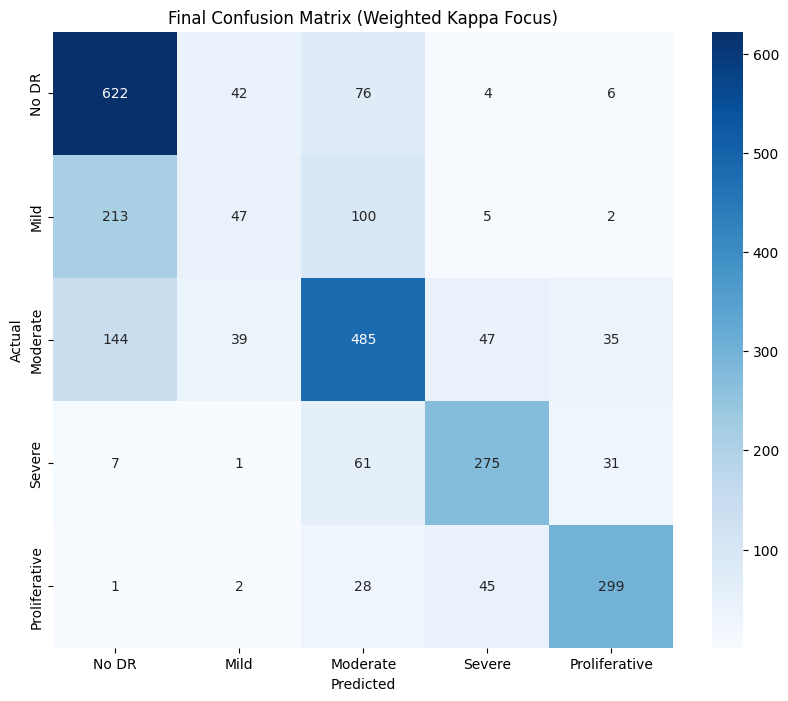

In [7]:

def final_evaluation(model, val_loader, device):
    model.load_state_dict(torch.load("custom_model.pth"))
    model.eval()
    
    all_preds, all_labs = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Final Evaluation"):
            with torch.amp.autocast('cuda'):
                outputs = model(images.to(device))
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labs.extend(labels.numpy())
    
    # 1. Classification Report (Precision, Recall, F1)
    classes = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]
    report = classification_report(all_labs, all_preds, target_names=classes)
    print("\nDetailed Classification Report:\n", report)
    
    # 2. Confusion Matrix Heatmap
    cm = confusion_matrix(all_labs, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Final Confusion Matrix (Weighted Kappa Focus)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("final_confusion_matrix.png")
    plt.show()

final_evaluation(model, val_loader, DEVICE)

In [8]:
def plot_training_results(history):
    epochs = range(1, len(history) + 1)
    train_loss = [h['train_loss'] for h in history]
    val_kappa = [h['val_kappa'] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss 
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, train_loss, color=color, marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot Kappa on the same chart (Secondary Axis) 
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Validation Kappa', color=color)
    ax2.plot(epochs, val_kappa, color=color, marker='s', label='Val Kappa')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss vs. Validation Kappa')
    fig.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

plot_training_results(history)

KeyError: 'train_loss'

# Grad Cam

In [ ]:
import cv2
import numpy as np

def generate_gradcam(model, img_tensor, label):
    model.eval()
    
    # 1. Hook into the last conv layer
    # For EfficientNet, the last conv layer is usually 'conv_head'
    features = []
    gradients = []

    def save_feature(module, input, output):
        features.append(output)
    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    handle_feat = model.conv_head.register_forward_hook(save_feature)
    handle_grad = model.conv_head.register_full_backward_hook(save_gradient)

    # 2. Forward pass
    output = model(img_tensor.to(DEVICE))
    score = output[:, label]
    
    # 3. Backward pass
    model.zero_grad()
    score.backward()

    # 4. Generate Heatmap
    grads = gradients[0].cpu().data.numpy()
    feats = features[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(2, 3))[0]
    
    cam = np.zeros(feats.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * feats[i]

    # 5. Clean up
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (640, 640))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    handle_feat.remove()
    handle_grad.remove()
    
    return cam

In [ ]:
def plot_gradcam(img_path, model, transform):
    # Load and prep image
    img_pil = Image.open(img_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0)
    
    # Get prediction
    with torch.no_grad():
        pred = torch.argmax(model(input_tensor.to(DEVICE)), 1).item()
    
    # Generate CAM
    cam = generate_gradcam(model, input_tensor, pred)
    
    # Overlay
    img_np = np.array(img_pil.resize((640, 640)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original (Pred: {pred})")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Focus")
    plt.show()

In [ ]:
# 1. Load the best weights back into the model
model.load_state_dict(torch.load("custom_model.pth"))

# 2. Pick a few images from the validation set to test
sample_paths = X_test[:5]  # Just the first 5 images for a quick check

for path in sample_paths:
    plot_gradcam(path, model, val_transform)